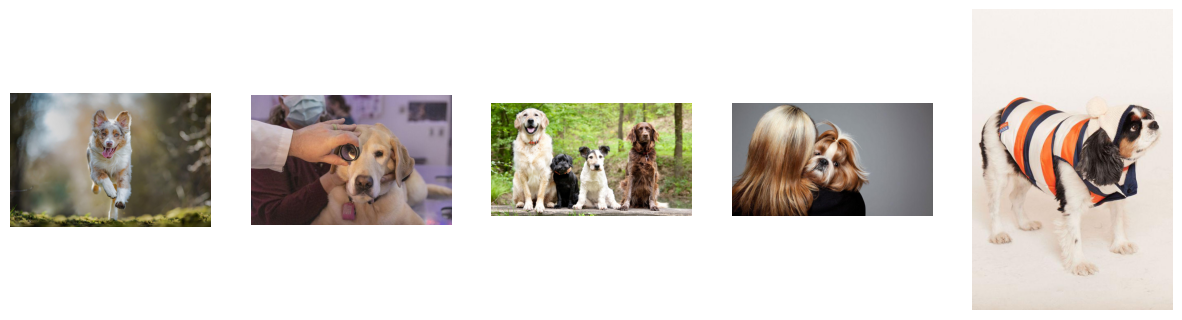

In [1]:
import os
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set the directory containing images
IMAGE_DIR = "/Users/sivaprasanth/Documents/Computer Vision/Computer-Vision/img/dogs"
NUM_CLUSTERS = 10  # Adjust the number of clusters based on your dataset

# Function to extract features using ORB (Oriented FAST and Rotated BRIEF)
def extract_features(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Initialize ORB detector
    orb = cv2.ORB_create()
    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return descriptors

# Function to create a feature database with fixed-length descriptors
def create_feature_database(image_dir):
    features = []
    image_paths = []
    
    all_descriptors = []  # To collect all descriptors for KMeans clustering

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            descriptors = extract_features(image_path)
            if descriptors is not None:
                all_descriptors.append(descriptors)
                image_paths.append(image_path)

    # Flatten the list of descriptors and apply KMeans
    all_descriptors_flat = np.vstack(all_descriptors)
    kmeans = KMeans(n_clusters=NUM_CLUSTERS)
    kmeans.fit(all_descriptors_flat)

    # Create feature vectors for each image based on cluster assignments
    for descriptors in all_descriptors:
        if descriptors is not None:
            # Predict cluster for each descriptor
            cluster_assignments = kmeans.predict(descriptors)
            # Create histogram of cluster assignments
            hist, _ = np.histogram(cluster_assignments, bins=np.arange(NUM_CLUSTERS + 1), density=True)
            features.append(hist)

    return np.array(features), image_paths, kmeans  # Return kmeans

# Function to find similar images
def find_similar_images(query_image_path, features, image_paths, kmeans):
    query_descriptors = extract_features(query_image_path)
    if query_descriptors is None:
        print("No features found in the query image.")
        return []

    # Create a histogram for the query image
    cluster_assignments = kmeans.predict(query_descriptors)
    query_hist, _ = np.histogram(cluster_assignments, bins=np.arange(NUM_CLUSTERS + 1), density=True)

    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features)

    # Find the nearest neighbors
    distances, indices = nbrs.kneighbors(query_hist.reshape(1, -1))
    similar_images = [image_paths[i] for i in indices.flatten()]
    
    return similar_images

# Function to display images
def display_images(image_paths):
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

# Main function
def main():
    # Create the feature database
    features, image_paths, kmeans = create_feature_database(IMAGE_DIR)

    # Upload a query image
    query_image_path = input("Enter the path to the query image: ")

    # Find similar images
    similar_images = find_similar_images(query_image_path, features, image_paths, kmeans)

    # Display similar images
    display_images(similar_images)

if __name__ == "__main__":
    main()